In [2]:
%env CUDA_VISIBLE_DEVICES = 7

env: CUDA_VISIBLE_DEVICES=7


In [3]:
from warnings import filterwarnings
filterwarnings("ignore")

from dataset import *
from feature_analysis3 import *

import seaborn as sns
from siuba import *
from plotnine import *
from plotnine import options
options.figure_size = (10,5)

In [4]:
model_string = 'swin_base_patch4_window7_224_imagenet'
model_options = get_model_options()
image_transforms = get_recommended_transforms(model_string)

model_name = model_options[model_string]['model_name']
train_type = model_options[model_string]['train_type']
model_call = model_options[model_string]['call']

In [5]:
target_imageset = 'oasis'
image_data = load_image_data(target_imageset)

In [6]:
stimulus_loader = DataLoader(dataset=StimulusSet(image_data.image_path, image_transforms), batch_size=64)

In [7]:
superlative_layers = pd.read_csv('superlative_layers.csv').set_index('model_string').to_dict(orient='index')
target_layer = superlative_layers[model_string]['model_layer']

In [8]:
feature_maps = get_all_feature_maps(model_string, stimulus_loader, numpy=False, layers_to_retain = [target_layer])

Feature Extraction (Batch):   0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
stimulus_features = get_feature_map_srps(feature_maps)

SRP Extraction (Layer):   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
subject_data = load_response_data('oasis', average = False)

In [12]:
ratings_tally = (subject_data >> gather('measurement', 'rating', _.arousal, _.valence, _.beauty) >>
                 filter(~_.rating.isna()) >> group_by(_.subject, _.measurement, _.image_type) >> count())

In [20]:
ratings_tally.groupby('measurement').nunique('subject')

,subject,image_type,n
measurement,,,
arousal,409,4,20
beauty,757,4,13
valence,413,4,13


In [11]:
ratings_tally >> arrange(_.n)

,subject,measurement,image_type,n
1492,374,beauty,Animal,28
1520,381,beauty,Animal,28
1528,383,beauty,Animal,28
1540,386,beauty,Animal,28
1552,389,beauty,Animal,28
...,...,...,...,...
6270,881679,arousal,Person,97
6274,883557,arousal,Person,97
6290,889512,arousal,Person,97
6294,891007,arousal,Person,97


In [13]:
ratings_tally >> group_by(_.measurement, _.subject) >> summarize(n = np.sum(_.n)) >> arrange(_.n)

,measurement,subject,n
293,arousal,691860,222
76,arousal,250724,224
106,arousal,303277,224
172,arousal,443389,224
230,arousal,548809,224
...,...,...,...
1574,valence,874041,225
1575,valence,877958,225
1576,valence,880735,225
1577,valence,881084,225


In [14]:
ratings_tally >> filter(_.measurement == 'beauty') >> arrange(_.n) >> group_by(_.image_type) >> distinct(_.n) 

In [16]:
image_tally = (subject_data >> gather('measurement', 'rating', _.arousal, _.valence, _.beauty) >>
                 filter(~_.rating.isna()) >> group_by(_.image_name, _.measurement, _.image_type) >> count())

In [17]:
image_tally >> group_by(_.measurement) >> summarize(count = np.sum(_.n))

,measurement,count
0,arousal,92015
1,beauty,170325
2,valence,92924


In [18]:
image_tally >> arrange(_.n)

,image_name,measurement,image_type,n
474,Chipmunk2.jpg,arousal,Animal,100
1101,Frustratedpose7.jpg,arousal,Person,100
1464,Memorial1.jpg,arousal,Scene,100
2163,School7.jpg,arousal,Person,100
0,Acorns1.jpg,arousal,Object,101
...,...,...,...,...
2641,Wedding5.jpg,beauty,Person,368
2650,Wedding8.jpg,beauty,Object,368
2665,Wolf2.jpg,beauty,Animal,368
2692,Yoga4.jpg,beauty,Person,368


In [39]:
oracle_data = (pd.read_csv('response/oasis_oracle_data.csv')
               .rename(columns={'item_count': 'image_count', 'category': 'image_type'}))

In [ ]:
oracle_data.groupby(['measurement','image_type'])['oracle_corr'].mean().reset_index()

In [ ]:
(ggplot(oracle_data, aes('image_type', 'oracle_corr')) + geom_jitter(width = 0.3, height = 0) + 
 geom_boxplot(outlier_alpha = 0) + facet_wrap('~measurement'))

In [48]:
output_dir = 'incoming/subject_regs/{}'.format(target_imageset)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_file = os.path.join(output_dir, model_string + '.csv')

if os.path.exists(output_file):
    subject_reg_data = pd.read_csv(output_file)

if not os.path.exists(output_file):

    if isinstance(target_features, torch.Tensor):
        target_features = target_features.numpy()

    data_i = copy(subject_data).merge(image_data, on = ['image_name'])

    score_dictlist = []
    for measurement in tqdm(['arousal','valence','beauty']):
        data_i_sub1 = data_i[['subject', 'image_name', 'image_type', measurement]]
        for image_type in tqdm(data_i['image_type'].unique().tolist() + ['Combo'], leave = False):
            if image_type != 'Combo':
                data_i_subset = data_i_sub1[data_i_sub1['image_type'] == image_type]
            if image_type == 'Combo':
                data_i_subset = data_i_sub1
            for subject in tqdm(data_i_subset['subject'].unique(), leave = False):
                group_data_i = (data_i_subset[data_i_subset['subject'] != subject].groupby('image_name')[measurement]
                                .mean().reset_index()[measurement]).to_numpy()
                subject_data_i = data_i_subset[data_i_subset['subject'] == subject][measurement].to_numpy()
                item_indices = np.argwhere(~np.isnan(subject_data_i)).flatten()
                if len(item_indices) > 10:
                    y, y_group = subject_data_i[item_indices], group_data_i[item_indices]

                    X = scale(target_features[item_indices,:])

                    alpha_values = [1000]
                    regression = RidgeCV(alphas=alpha_values, store_cv_values=True,
                                         scoring='explained_variance').fit(X,y)

                    ridge_gcv_score, ridge_gcv_alpha = regression.best_score_, regression.alpha_
                    y_pred = regression.cv_values_[:, alpha_values.index(ridge_gcv_alpha)]

                    for alpha_value in alpha_values:
                        y_pred = regression.cv_values_[:, alpha_values.index(alpha_value)]

                        for score_type in scoring_metrics:
                            ridge_gcv_score = scoring_metrics[score_type](y, y_pred)

                            score_dictlist.append({'model': model_name, 'train_type': train_type, 
                                                   'model_layer_index': model_layer_index+1,
                                                   'model_layer': model_layer,
                                                   'subject': subject, 
                                                   'measurement': measurement,
                                                   'image_type': image_type,
                                                   'image_count': len(item_indices),
                                                   'score_type': score_type,
                                                   'score': ridge_gcv_score, 
                                                   'alpha': regression.alpha_})

    subject_reg_data = pd.DataFrame(score_dictlist)
    subject_reg_data.to_csv(output_file, index = None)

In [40]:
oracle_reg_data = subject_reg_data.merge(oracle_data, on = ['measurement','image_type','image_count','subject'])

In [49]:
(subject_reg_data[subject_reg_data['score_type'] == 'pearson_r']
 .groupby(['measurement', 'image_type'])['score'].mean().reset_index())

,measurement,image_type,score
0,arousal,Animal,0.032964
1,arousal,Combo,0.458475
2,arousal,Object,0.008462
3,arousal,Person,0.100227
4,arousal,Scene,0.099980
5,beauty,Animal,0.091156
6,beauty,Combo,0.478387
7,beauty,Object,0.102816
8,beauty,Person,0.115225
9,beauty,Scene,0.090719


In [42]:
(oracle_reg_data.groupby(['score_type','measurement','image_type'])['score','oracle_corr']
 .corr().iloc[0::2,-1].reset_index().drop('level_3', axis = 1))

,score_type,measurement,image_type,oracle_corr
0,ev_score,arousal,Animal,-0.040526
1,ev_score,arousal,Combo,0.310108
2,ev_score,arousal,Object,-0.057537
3,ev_score,arousal,Person,0.057500
4,ev_score,arousal,Scene,0.093246
5,ev_score,beauty,Animal,0.330742
6,ev_score,beauty,Combo,0.687319
7,ev_score,beauty,Object,0.256236
8,ev_score,beauty,Person,0.206338
9,ev_score,beauty,Scene,0.282550


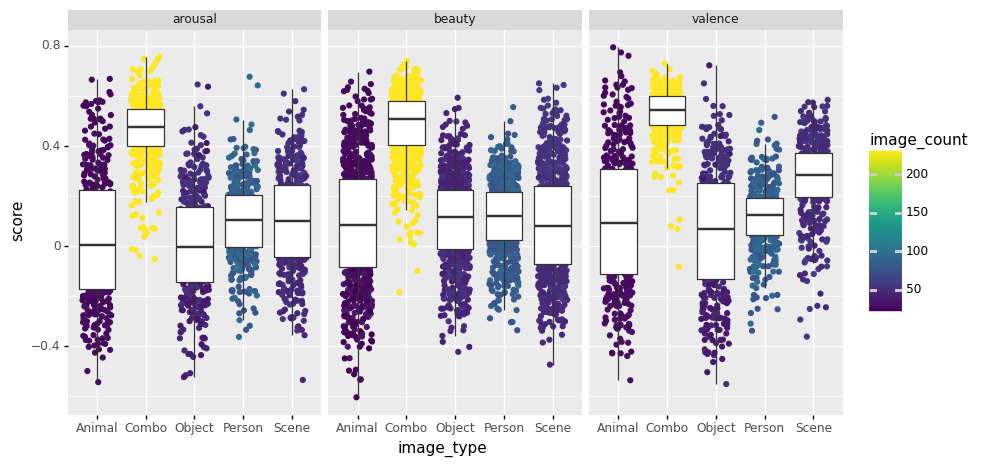

<ggplot: (8747859002333)>

In [43]:
plot_data = subject_reg_data[subject_reg_data['score_type'] == 'pearson_r']
(ggplot(plot_data, aes('image_type', 'score')) + 
 geom_jitter(aes(color = 'image_count'), width = 0.3, height = 0) + 
 geom_boxplot(outlier_alpha = 0) + facet_wrap('~measurement'))

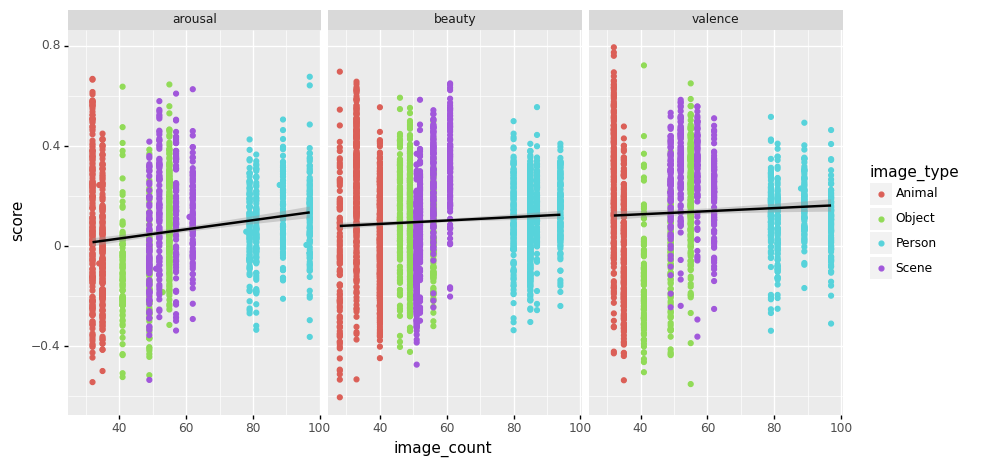

<ggplot: (8747857071261)>

In [44]:
plot_data = subject_reg_data[subject_reg_data['score_type'] == 'pearson_r'].reset_index()
plot_data = plot_data[plot_data['image_type'] != 'Combo'].reset_index()
(ggplot(plot_data, aes(x = 'image_count', y = 'score')) + facet_wrap('~measurement') +
 geom_point(aes(color = 'image_type')) + geom_smooth(method = 'lm'))

In [45]:
for measurement in ['beauty', 'arousal', 'valence']:
    subject_reg_data_ = subject_reg_data[subject_reg_data['score_type'] == 'pearson_r'].reset_index()
    oracle_regs = (pd.concat([oracle_data, subject_reg_data_[['score']]], axis = 1) >> 
                   filter(_.image_type == 'Combo', _.measurement == measurement))
    x = oracle_regs['oracle_corr']
    y = oracle_regs['score']
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    corr = np.round(pearsonr(x[~nas], y[~nas]),5)
    print('{} (n = {}), r = {}, p = {}'.format(measurement, len(oracle_regs), corr[0], corr[1]))

beauty (n = 757), r = 0.71559, p = 0.0
arousal (n = 409), r = 0.32414, p = 0.0
valence (n = 413), r = 0.68611, p = 0.0


In [46]:
for measurement in ['beauty', 'arousal', 'valence']:
    for category in ['Animal', 'Object', 'Person', 'Scene', 'Combo']:
        subject_reg_data_ = subject_reg_data[subject_reg_data['score_type'] == 'pearson_r'].reset_index()
        oracle_regs = (pd.concat([oracle_data, subject_reg_data_[['score']]], axis = 1) >> 
                       filter(_.image_type == category, _.measurement == measurement))
        x = oracle_regs['oracle_corr']
        y = oracle_regs['score']
        nas = np.logical_or(np.isnan(x), np.isnan(y))
        corr = np.round(pearsonr(x[~nas], y[~nas]),5)
        print('{}, {} (n = {}), r = {}, p = {}'.format(measurement, category, len(oracle_regs), corr[0], corr[1]))

beauty, Animal (n = 757), r = 0.33116, p = 0.0
beauty, Object (n = 757), r = 0.24967, p = 0.0
beauty, Person (n = 757), r = 0.18444, p = 0.0
beauty, Scene (n = 757), r = 0.24768, p = 0.0
beauty, Combo (n = 757), r = 0.71559, p = 0.0
arousal, Animal (n = 409), r = -0.03118, p = 0.5366
arousal, Object (n = 409), r = -0.01692, p = 0.73496
arousal, Person (n = 409), r = 0.07198, p = 0.14617
arousal, Scene (n = 409), r = 0.0613, p = 0.21835
arousal, Combo (n = 409), r = 0.32414, p = 0.0
valence, Animal (n = 413), r = 0.08316, p = 0.09183
valence, Object (n = 413), r = 0.05232, p = 0.2888
valence, Person (n = 413), r = -0.00268, p = 0.95671
valence, Scene (n = 413), r = 0.45431, p = 0.0
valence, Combo (n = 413), r = 0.68611, p = 0.0


In [ ]:
subject_reg_data_ = subject_reg_data[subject_reg_data['score_type'] == 'pearson_r'].reset_index()
oracle_regs = (pd.concat([oracle_data, subject_reg_data_[['score']]], axis = 1) >> 
               filter(_.image_type == 'Combo', _.measurement == 'beauty'))
sns.lmplot(x = 'score', y = 'oracle_corr', data = oracle_regs);

In [ ]:
splithalf_oracle_beauty = []
for i in tqdm(range(1000)):
    subject_reg_data_ = subject_reg_data[subject_reg_data['score_type'] == 'pearson_r'].reset_index()
    oracle_regs = (pd.concat([oracle_data, subject_reg_data_[['score']]], axis = 1) >> 
                   filter(_.image_type == 'Combo', _.measurement == 'beauty'))
    oracle_regs = oracle_regs.sample(n = 400)
    x = oracle_regs['oracle_corr']
    y = oracle_regs['score']
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    corr = np.round(pearsonr(x[~nas], y[~nas]),5)
    splithalf_oracle_beauty.append({'measurement': 'beauty', 'n': len(oracle_regs),
                                    'r': corr[0], 'p': corr[1]})
    #print('{} (n = {}), r = {}, p = {}'.format(measurement, len(oracle_regs), corr[0], corr[1]))
splithalf_oracle_beauty = pd.DataFrame(splithalf_oracle_beauty)

In [ ]:
splithalf_oracle_beauty['r'].mean()

In [ ]:
sns.distplot(splithalf_oracle_beauty['r']);

In [ ]:
splithalf_valence_beauty = []
for i in tqdm(range(1000)):
    subject_reg_data_ = subject_reg_data[subject_reg_data['score_type'] == 'pearson_r'].reset_index()
    oracle_regs = (pd.concat([oracle_data, subject_reg_data_[['score']]], axis = 1) >> 
                   filter(_.image_type == 'Combo', _.measurement == 'valence'))
    oracle_regs = oracle_regs.sample(n = 400)
    x = oracle_regs['oracle_corr']
    y = oracle_regs['score']
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    corr = np.round(pearsonr(x[~nas], y[~nas]),5)
    splithalf_valence_beauty.append({'measurement': 'beauty', 'n': len(oracle_regs),
                                    'r': corr[0], 'p': corr[1]})
    #print('{} (n = {}), r = {}, p = {}'.format(measurement, len(oracle_regs), corr[0], corr[1]))
splithalf_valence_beauty = pd.DataFrame(splithalf_valence_beauty)

In [ ]:
splithalf_valence_beauty['r'].mean()

In [ ]:
sns.distplot(splithalf_valence_beauty['r']);

### Vessel Dataset

In [20]:
subject_data = load_response_data('vessel', average = False)
image_data = load_image_data('vessel')

In [21]:
stimulus_loader = DataLoader(dataset=StimulusSet(image_data.image_path, image_transforms), batch_size=64)

In [22]:
feature_maps = get_all_feature_maps(model_string, stimulus_loader, numpy=False, layers_to_retain = [target_layer])

Feature Extraction (Batch):   0%|          | 0/9 [00:00<?, ?it/s]

In [23]:
stimulus_features = get_feature_map_srps(feature_maps)

SRP Extraction (Layer):   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
subject_data.groupby(['image_type','subject']).beauty.mean().reset_index().groupby('image_type').beauty.count()

image_type
are    19
ari    17
art    24
fac    20
lsc    18
Name: beauty, dtype: int64

In [25]:
oracle_data = (pd.read_csv('response/vessel_oracle_data.csv')
               .rename(columns={'item_count':'image_count', 'category': 'image_type'}))

In [26]:
subject_data

,subject,image_type,image_name,beauty
0,1,are,aep_001.jpg,3.666667
1,1,are,aep_002.jpg,4.333333
2,1,are,aep_004.jpg,1.000000
3,1,are,aep_005.jpg,5.666667
4,1,are,aep_006.jpg,6.333333
...,...,...,...,...
10933,24,art,art_105.jpg,1.000000
10934,24,art,art_106.jpg,1.000000
10935,24,art,art_107.jpg,1.000000
10936,24,art,art_108.jpg,1.500000


In [27]:
score_dictlist = []
data_i = copy(subject_data).merge(image_data, on = ['image_name'])
for model_layer_index, model_layer in enumerate(tqdm([target_layer], desc = 'Regression (Layer)')):
    target_features = stimulus_features[model_layer]
    if isinstance(stimulus_features[model_layer], torch.Tensor):
        target_features = target_features.numpy()

    for measurement in [col for col in subject_data.columns if col in ['arousal','beauty','valence']]:
        data_i_sub1 = data_i[['subject', 'image_name', 'image_type', measurement]]
        for image_type in tqdm(data_i['image_type'].unique().tolist() + ['Combo'], leave = False):
            if image_type != 'Combo':
                data_i_subset = data_i_sub1[data_i_sub1['image_type'] == image_type]
            if image_type == 'Combo':
                data_i_subset = data_i_sub1
            for subject in tqdm(data_i_subset['subject'].unique(), leave = False):
                group_data_i = (data_i_subset[data_i_subset['subject'] != subject].groupby('image_name')[measurement]
                                .mean().reset_index()[measurement]).to_numpy()
                subject_data_i = data_i_subset[data_i_subset['subject'] == subject][measurement].to_numpy()
                item_indices = np.argwhere(~np.isnan(subject_data_i)).flatten()
                if len(item_indices) > 10:
                    y, y_group = subject_data_i[item_indices], group_data_i[item_indices]
                    
                    X = scale(target_features[item_indices,:])
                    
                    alpha_values = [1000]
                    regression = RidgeCV(alphas=alpha_values, store_cv_values=True,
                                         scoring='explained_variance').fit(X,y)

                    ridge_gcv_score, ridge_gcv_alpha = regression.best_score_, regression.alpha_
                    y_pred = regression.cv_values_[:, alpha_values.index(ridge_gcv_alpha)]

                    for alpha_value in alpha_values:
                        y_pred = regression.cv_values_[:, alpha_values.index(alpha_value)]

                        for score_type in scoring_metrics:
                            ridge_gcv_score = scoring_metrics[score_type](y, y_pred)

                            score_dictlist.append({'model': model_name, 'train_type': train_type, 
                                                 'model_layer_index': model_layer_index+1,
                                                 'model_layer': model_layer,
                                                 'subject': subject, 
                                                 'measurement': measurement,
                                                 'image_type': image_type,
                                                 'image_count': len(item_indices),
                                                 'score_type': score_type,
                                                 'score': ridge_gcv_score, 
                                                 'alpha': regression.alpha_})

subject_reg_data = pd.DataFrame(score_dictlist)

Regression (Layer):   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
#subject_reg_data.to_csv('vessel_subject_regressions.csv', index = None)

In [28]:
oracle_reg_data = subject_reg_data.merge(oracle_data, on = ['image_type','subject'])

In [29]:
oracle_reg_data.image_type.unique()

array(['are', 'ari', 'art', 'fac', 'lsc', 'Combo'], dtype=object)

In [ ]:
(oracle_reg_data.groupby(['score_type','measurement','image_type'])['score','oracle_corr']
 .corr().iloc[0::2,-1].reset_index().drop('level_3', axis = 1))

In [ ]:
for image_type in oracle_reg_data.image_type.unique():
    oracle_reg_data_i = oracle_reg_data >> filter(_.image_type == image_type)
    corr = np.round(pearsonr(oracle_reg_data_i['score'], oracle_reg_data_i['oracle_corr']), 5)
    print('{} (n = {}), r = {}, p = {}'.format(image_type, len(oracle_reg_data_i), corr[0], corr[1]))
    sns.lmplot(x = 'score', y = 'oracle_corr', data = oracle_reg_data_i);